In [1]:
import os
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
os.chdir(os.path.split(workbookDir)[0])

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Synthetic data generation

In [3]:
import warnings
warnings.filterwarnings(action='ignore', message="numpy.dtype size changed")

In [5]:
import pandas as pd

## Load transactions

In [6]:
data = pd.read_csv('data/transactions.csv')
data.head(10)

,Unnamed: 0,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,mean_income
0,0,695247,2378,1993-01-01,1,2.0,700.0,700.0,NaN,NaN,NaN,[ 11271.53754941]
1,1,695250,2378,1993-01-22,1,2.0,7268.0,7968.0,NaN,NaN,NaN,[ 11271.53754941]
2,2,695266,2378,1993-01-23,1,2.0,14440.0,22408.0,NaN,NaN,NaN,[ 11271.53754941]
3,3,695262,2378,1993-01-24,1,2.0,49752.0,72160.0,NaN,NaN,NaN,[ 11271.53754941]
4,4,695265,2378,1993-01-26,1,2.0,21899.0,94059.0,NaN,NaN,NaN,[ 11271.53754941]
5,5,695560,2378,1993-01-31,0,3.0,34700.0,59453.7,NaN,NaN,NaN,[ 11271.53754941]
6,6,3608592,2378,1993-01-31,1,NaN,94.7,94153.7,2,NaN,NaN,[ 11271.53754941]
7,7,695272,2378,1993-02-05,1,2.0,30192.0,89645.7,NaN,NaN,NaN,[ 11271.53754941]
8,8,695340,2378,1993-02-07,0,0.0,9612.0,80033.7,4,EF,1222903.0,[ 11271.53754941]
9,9,695270,2378,1993-02-11,1,2.0,31038.0,111071.7,NaN,NaN,NaN,[ 11271.53754941]


## Clean dataset

* Leave target columns only (so far: type, operation, amount)
* Filter NaN values
* Convert columns to appropriate type

In [7]:
data = data[['account_id', 'type', 'operation', 'amount']]
data = data.dropna()
data = data[data['type'] != 'VYBER']
data['account_id'] = data['account_id'].astype(dtype='int32')
id_normalization = {x: n for n, x in enumerate(data['account_id'].unique())}
data['account_id'] = data['account_id'].map(arg=id_normalization)
data['type'] = data['type'].astype(dtype='int')
data['type'] = data['type'].astype(dtype='category')
data['operation'] = data['operation'].astype(dtype='int')
data['operation'] = data['operation'].astype(dtype='category')
data['amount'] = data['amount'].astype(dtype='float32')
data.head(10)

,account_id,type,operation,amount
0,0,1,2,700.0
1,0,1,2,7268.0
2,0,1,2,14440.0
3,0,1,2,49752.0
4,0,1,2,21899.0
5,0,0,3,34700.0
7,0,1,2,30192.0
8,0,0,0,9612.0
9,0,1,2,31038.0
10,0,0,3,25200.0


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
data, test = train_test_split(data, test_size=0.2, random_state=42)

## Train model and synthesized data

In [10]:
from synthesized.core import BasicSynthesizer

Copyright (C) Synthesized Ltd. - All Rights Reserved
License key: EE6B-6720-67A2-32F3-3138-2D31-322D-B531
Expires at: 2018-12-31 00:00:00


In [11]:
with BasicSynthesizer(data=data) as synthesizer:
    synthesizer.learn(data=data, verbose=5000)
    synthesized = synthesizer.synthesize(n=10000)

value types:
account_id continuous-integer
type categorical
operation categorical
amount continuous
5000: 1.49e+08
10000: 1.02e+08
15000: 1.10e+08
20000: 9.67e+07
25000: 1.97e+07
30000: 4.74e+07
35000: 7.16e+06
40000: 3.40e+06
45000: 1.34e+07
50000: 5.16e+06


## Display synthesized data

In [18]:
synthesized.head(5)

,account_id,type,operation,amount
0,178,0,0,1877.514160
1,166,0,3,1789.016357
2,527,0,3,6065.577148
3,611,0,3,7040.026367
4,787,1,2,9014.311523


In [19]:
data.head(5)

,account_id,type,operation,amount
915723,3198,1,1,32768.0
670839,1902,1,2,1800.0
784950,2448,0,0,9641.0
880239,2979,0,3,6600.0
611740,1675,0,3,25500.0


### TODO: move to testing

In [20]:
data = data.astype(synthesized.dtypes)

In [21]:
test = data.astype(synthesized.dtypes)

# Visualization of original and synthetic data

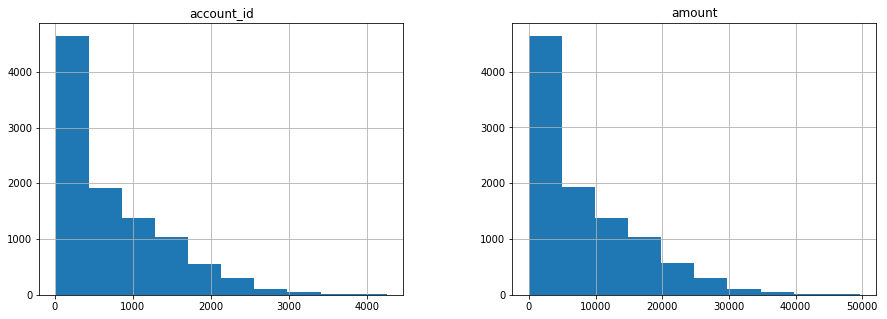

In [29]:
synthesized.hist(figsize=(15,5))
None

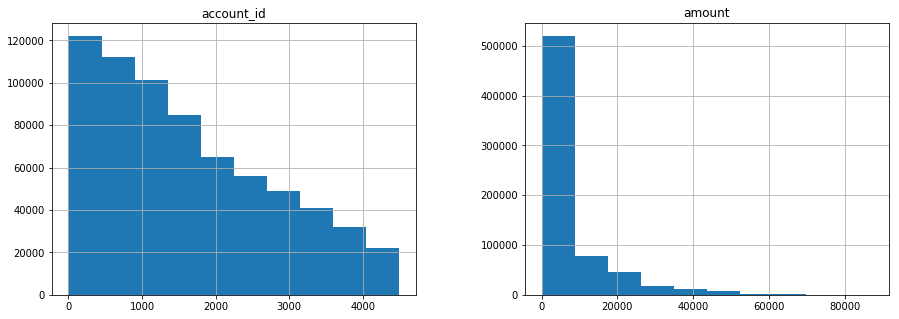

In [30]:
data.hist(figsize=(15,5))
None

# Tests to confirm the utility of synthetic data 

In [32]:
from synthesized.testing.testing_environment import Testing, ColumnType
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [34]:
testing = Testing(synthesizer, data, test, synthesized)

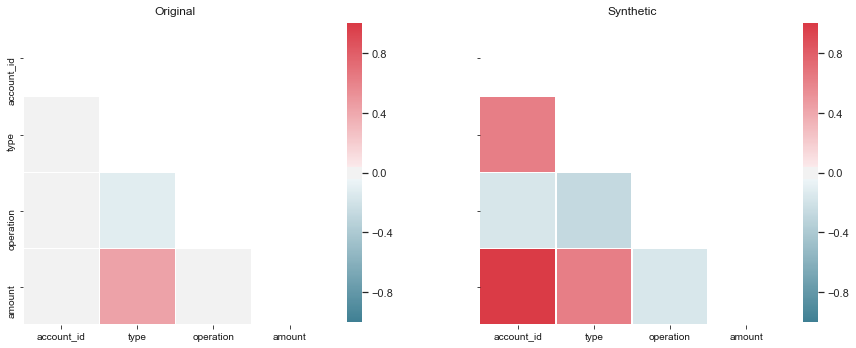

In [35]:
testing.show_corr_matrices()

In [36]:
testing.estimate_utility(classifier=DecisionTreeClassifier(), regressor=DecisionTreeRegressor())

,target_column,estimator,dummy_original_score,original_score,synth_score,orig_error,synth_error,score_utility,error_utility
0,account_id,DecisionTreeRegressor,9.996459e-11,0.358438,0.000000,938.947206,1751.617726,0.0,0.536046
1,account_id (categorical reduction),DecisionTreeClassifier,1.782389e-01,0.487833,0.163482,0.512167,0.836530,0.0,0.612252
2,amount,DecisionTreeRegressor,0.000000e+00,0.549501,0.000000,6776.634858,20579.036382,0.0,0.329298
3,amount (categorical reduction),DecisionTreeClassifier,7.582629e-01,0.838907,0.269979,0.161093,0.729868,0.0,0.220715
4,operation,DecisionTreeRegressor,0.000000e+00,0.999029,0.000000,0.039059,1.968754,0.0,0.019839
5,operation (categorical reduction),DecisionTreeClassifier,4.880610e-01,0.998182,0.266235,0.001818,0.749075,0.0,0.002427
6,type,DecisionTreeRegressor,0.000000e+00,1.000000,0.000000,0.000000,0.498490,0.0,0.000000
7,type (categorical reduction),DecisionTreeClassifier,7.405871e-01,1.000000,0.729759,0.000000,0.242257,0.0,0.000000


In [37]:
testing.compare_marginal_distributions(target_column='operation', conditional_column='amount')

,amount,operation EMD
0,"[0.0, 21825.0)",0.492262
1,"[21825.0, 43650.0)",0.395408
2,"[43650.0, 65475.0)",0.541841
3,"[65475.0, 87300.0)",inf


In [38]:
testing.compare_marginal_distributions(target_column='type', conditional_column='amount', bins=10)

,amount,type EMD
0,"[0.0, 8730.0)",0.000000
1,"[8730.0, 17460.0)",0.140015
2,"[17460.0, 26190.0)",0.030009
3,"[26190.0, 34920.0)",0.222515
4,"[34920.0, 43650.0)",0.000000
5,"[43650.0, 52380.0)",0.000000
6,"[52380.0, 61110.0)",inf
7,"[61110.0, 69840.0)",inf
8,"[69840.0, 78570.0)",inf
9,"[78570.0, 87300.0)",inf


# Tests to confirm the security of original data 

In [53]:
from synthesized.testing.linkage_attack import identify_attacks, Column, show_attacked_data, eradicate_attacks

## Focus on a small chunk of original data for demo purposes

In [40]:
data_orig_reduced = data.head(30000)

## Define schema for security checks

Each attribute in a dataset has the following properties to be specified by the user
1. "key_attribute" - whether the attribute can be available to the attacker as background knowledge 
2. "sensitive" - whether the attribute is SPI 
3. "categorical" - wtether the attribute is a categorical variable

In [28]:
schema = {
    'type': Column(key_attribute=False, sensitive=True, categorical=True),
    'operation': Column(key_attribute=True, sensitive=True, categorical=True),
    'amount': Column(key_attribute=True, sensitive=True, categorical=False),
    'account_id': Column(key_attribute=False, sensitive=False, categorical=False),
}

## Identify and demonstrate vulnerabilities in synthetic data

In [29]:
attacks = identify_attacks(data_orig_reduced, synthesized, schema)

In [30]:
len(attacks)

1293

In [31]:
show_attacked_data(data_orig_reduced, synthesized, attacks[3], schema)

attribute under attack:  operation

bacground knowledge:  amount


 original df subset: 
          account_id  type  operation  amount
73484         171.0     0          3    30.0
120253        284.0     0          3    30.0
539749       1425.0     0          3    30.0
11690          26.0     0          3    30.0
911137       3166.0     0          3    30.0
764169       2339.0     0          3    30.0
242623        590.0     0          3    30.0
541120       1429.0     0          3    30.0
360068        898.0     0          3    30.0
391445        986.0     0          3    30.0
26105          59.0     0          3    30.0
878330       2967.0     0          3    30.0
1042390      4281.0     0          3    30.0
332440        823.0     0          3    30.0
120343        284.0     0          3    30.0
503325       1311.0     0          3    30.0
698310       2021.0     0          3    30.0
1003457      3865.0     0          3    30.0
169893        406.0     0          3    30.0
570227    

## Clear the synthetic dataset from vulnerabilities

In [32]:
cleared_df = eradicate_attacks(data_orig_reduced, synthesized, attacks, schema)

remaining attacks :  1293


/Users/denisborovikov/IdeaProjects/synthesized/synthesized/testing/testing_environment.py:236: RuntimeWarning:

invalid value encountered in true_divide

/Users/denisborovikov/IdeaProjects/synthesized/synthesized/testing/testing_environment.py:235: RuntimeWarning:

invalid value encountered in true_divide



remaining attacks :  67
remaining attacks :  3


## Demonstrate the security of synthetic data

In [33]:
new_attacks = identify_attacks(data_orig_reduced, cleared_df, schema)

In [34]:
len(new_attacks)

0

## Demonstrate the utility of synthetic data cleared from all vulnerabilities

In [35]:
testing = Testing(data, cleared_df, synthesized, schema={
    'type': ColumnType.CATEGORICAL,
    'operation': ColumnType.CATEGORICAL,
    'amount': ColumnType.CONTINUOUS,
})

In [36]:
testing.estimate_utility(classifier=DecisionTreeClassifier(), regressor=DecisionTreeRegressor())

,target_column,estimator,dummy_original_score,original_score,synth_score,orig_error,synth_error,score_utility,error_utility
0,amount,DecisionTreeRegressor,0.000000,0.000000,0.092009,14303.090350,8334.100440,0.000000,1.716213
1,amount (categorical reduction),DecisionTreeClassifier,0.105607,0.105607,0.511185,0.894393,0.488815,0.000000,1.829716
2,operation,DecisionTreeClassifier,0.017723,0.130763,0.401553,0.869237,0.598447,3.395535,1.452489
3,type,DecisionTreeClassifier,0.661488,0.355649,0.371179,0.644351,0.628649,NaN,1.024977


## Demonstrate the synthetic dataset to be released to the user

In [37]:
synthesized

,account_id,type,operation,amount
0,314,0,0,3482.375244
1,1068,0,3,12373.549805
2,629,1,0,7045.999023
3,15,0,3,9.458170
4,410,1,0,4617.419434
5,328,0,0,3623.130127
6,15,0,3,9.458170
7,477,0,3,5429.196289
8,15,0,3,9.458170
9,1435,0,3,16667.007812
